# ZFNet

Source: https://towardsdatascience.com/zfnet-an-explanation-of-paper-with-code-f1bd6752121d

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import imageio as iio
import os
import xml.etree.ElementTree as ET
import cv2
import numpy as np
from PIL import Image
from numba import cuda  # https://stackoverflow.com/a/52354865/6476994
import keras
from keras.utils.np_utils import to_categorical
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import csv
import re
from datetime import datetime
import collections
from readInImages import readInImages
from readInAnnotations import readInAnnotations

In [2]:
# allows all images to be displayed at once (else only displays the last call to plt.imshow())
# https://stackoverflow.com/a/41210974
def displayImage(image, caption = None, colour = None) -> None:
    plt.figure()
    if(colour != None):
        plt.imshow(image, cmap=colour)
    else:
        plt.imshow(image)
        
    if(caption != None):
        # display caption below picture (https://stackoverflow.com/a/51486361)
        plt.figtext(0.5, 0.01, caption, wrap=True, horizontalalignment='center', fontsize=12)

In [3]:
# free up GPU if it didn't after the last run
cuda.select_device(0)
cuda.close()

## Read in dataset

* first argument is the `using_batch_generator` flag
* second argument is `do_preprocessing`, which will perform image manipulations for the purposes of enhancing training performance
* all other arguments are the datasets - e.g., a folder ('20160724_July') with additional folders ('BB01', 'BB02', ..., 'BBXY'), each containing a set of images)

In [4]:
%run readInDataset.py true false 20160724_July 20160829_August

args: ['readInDataset.py', 'true', 'false', '20160724_July', '20160829_August']
using_batch_generator? True
doing pre-processing? False
dataset_names: ['20160724_July', '20160829_August']
reading in images and labels for dataset: 20160724_July
all_folders_for_curr_dataset: ['BB01', 'BB02', 'BB03', 'BB04', 'BB05', 'BB06', 'BB07', 'BB08', 'BB09', 'BB10', 'BB11', 'BB12', 'BB13', 'BB14', 'BB15', 'BB16', 'BB17', 'BB18', 'BB19', 'BB20', 'BB21', 'BB22', 'BB23', 'BB24', 'BB25', 'BB26', 'BB27', 'BB28', 'BB29', 'BB30', 'BB31', 'BB32', 'BB33', 'BB34', 'BB35', 'BB36']
reading in labels for subset: BB01
returning labelList of length: 285
reading in images for subset: BB01
all_image_filenames length: 285
done current subset
reading in labels for subset: BB02
returning labelList of length: 45
reading in images for subset: BB02
all_image_filenames length: 45
done current subset
reading in labels for subset: BB03
returning labelList of length: 230
reading in images for subset: BB03
all_image_filenames 

In [5]:
class CustomGenerator(keras.utils.Sequence):    
    def __init__(self, images, labels, batch_size):
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
    
    def __len__(self):
        return (np.ceil(len(self.images) / float(self.batch_size))).astype(np.int)

    def __getitem__(self, idx):
        batch_x = self.images[idx * self.batch_size : (idx+1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]
        
        return batch_x, np.array(batch_y)

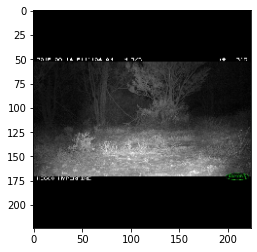

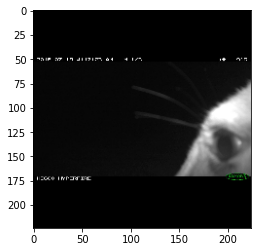

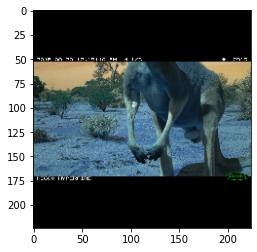

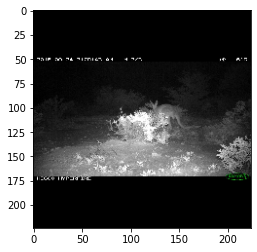

In [6]:
batch_size = 128

num_len_train = int(0.8 * len(training_images))

ttraining_images = training_images[:num_len_train]
ttraining_labels = training_labels[:num_len_train]

valid_images = training_images[num_len_train:]
valid_labels = training_labels[num_len_train:]

training_images = ttraining_images
training_labels = ttraining_labels

# show a few samples
displayImage(training_images[0])
displayImage(training_images[10])
displayImage(training_images[100])
displayImage(training_images[1000])

training_batch_generator = CustomGenerator(training_images, training_labels, batch_size)
validation_batch_generator = CustomGenerator(valid_images, valid_labels, batch_size)

## Train the model

In [13]:
model = tf.keras.models.Sequential([                                    
    tf.keras.layers.Conv2D(96, (7, 7), strides=(2, 2), activation='relu',input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(3, strides=2),
    tf.keras.layers.Lambda(lambda x: tf.image.per_image_standardization(x)),
    tf.keras.layers.Conv2D(256, (5, 5), strides=(2, 2), activation='relu'),
    tf.keras.layers.MaxPooling2D(3, strides=2),
    tf.keras.layers.Lambda(lambda x: tf.image.per_image_standardization(x)),
    tf.keras.layers.Conv2D(384, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(384, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(3, strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096),
    tf.keras.layers.Dense(4096),
    tf.keras.layers.Dense(len(classes), activation='softmax')
])


model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.01, momentum=0.9), \
              loss='categorical_crossentropy', \
              metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(5)])

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', \
    factor=0.1, patience=1, \
    min_lr=0.00001)

model.fit(training_batch_generator,
          validation_data=validation_batch_generator,
          epochs=20,
          callbacks=[reduce_lr])

Epoch 1/20


/home/luke/.local/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/tmp/ipykernel_123806/4098404636.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return (np.ceil(len(self.images) / float(self.batch_size))).astype(np.int)


89/89 [==============================] - 15s 161ms/step - loss: 1.2204 - accuracy: 0.6266 - top_k_categorical_accuracy: 0.9727 - val_loss: 0.8961 - val_accuracy: 0.6738 - val_top_k_categorical_accuracy: 0.9912 - lr: 0.0100
Epoch 2/20
89/89 [==============================] - 14s 159ms/step - loss: 0.8847 - accuracy: 0.6755 - top_k_categorical_accuracy: 0.9931 - val_loss: 0.8486 - val_accuracy: 0.6696 - val_top_k_categorical_accuracy: 0.9902 - lr: 0.0100
Epoch 3/20
89/89 [==============================] - 14s 161ms/step - loss: 0.8175 - accuracy: 0.7019 - top_k_categorical_accuracy: 0.9930 - val_loss: 0.7842 - val_accuracy: 0.7378 - val_top_k_categorical_accuracy: 0.9919 - lr: 0.0100
Epoch 4/20
89/89 [==============================] - 15s 165ms/step - loss: 0.7366 - accuracy: 0.7333 - top_k_categorical_accuracy: 0.9932 - val_loss: 0.7779 - val_accuracy: 0.7290 - val_top_k_categorical_accuracy: 0.9912 - lr: 0.0100
Epoch 5/20
89/89 [==============================] - 14s 162ms/step - loss: 

## Use test set to assess trained model's performance

### Evaluate

In [14]:
print('test_images shape: {}'.format(test_images.shape))
print('test_labels shape: {}'.format(test_labels.shape))

results = model.evaluate(test_images,test_labels)
print('loss: {}'.format(results[0]))
print('accuracy: {}'.format(results[1]))
print('top_k_categorical_accuracy: {}'.format(results[2]))

test_images shape: (3556, 224, 224, 3)
test_labels shape: (3556, 10)
  1/112 [..............................] - ETA: 3s - loss: 0.3595 - accuracy: 0.8750 - top_k_categorical_accuracy: 1.0000

2022-06-07 11:01:31.458233: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 535277568 exceeds 10% of free system memory.


112/112 [==============================] - 2s 14ms/step - loss: 0.4092 - accuracy: 0.8611 - top_k_categorical_accuracy: 0.9989
loss: 0.4091629981994629
accuracy: 0.8610798716545105
top_k_categorical_accuracy: 0.9988751411437988


### Predict and print classification report

In [15]:
predictions = (model.predict(test_images) > 0.5).astype("int32")

112/112 [==============================] - 2s 13ms/step


In [16]:
print("test_classes: {}".format(test_classes))
print("train classes count: {}".format(counter_test))
# classification_report uses alphabetic ordering of the classes, so to match the encoded labels to the target_names, provide a sortest list of classes
# https://stackoverflow.com/a/48495303
sorted_test_classes = sorted(test_classes)
print(classification_report(test_labels, predictions, target_names=sorted_test_classes))

test_classes: ['Kangaroo', 'Empty photo', 'Emu', 'Human Presense/Deployment', 'Fox', 'Cat', 'Rabbit', 'Other', 'Bird', 'Dog']
train classes count: Counter({'Kangaroo': 2370, 'Empty photo': 653, 'Emu': 219, 'Human Presense/Deployment': 183, 'Fox': 66, 'Cat': 39, 'Rabbit': 13, 'Bird': 9, 'Other': 3, 'Dog': 1})
                           precision    recall  f1-score   support

                     Bird       0.00      0.00      0.00         9
                      Cat       0.69      0.28      0.40        39
                      Dog       0.00      0.00      0.00         1
              Empty photo       0.75      0.69      0.72       653
                      Emu       0.88      0.81      0.84       219
                      Fox       0.77      0.30      0.43        66
Human Presense/Deployment       0.76      0.66      0.71       183
                 Kangaroo       0.92      0.94      0.93      2370
                    Other       1.00      0.33      0.50         3
                   

/home/luke/miniconda3/envs/cv-project-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luke/miniconda3/envs/cv-project-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Confusion matrix

In [17]:
matrix = confusion_matrix(test_labels.argmax(axis=1), predictions.argmax(axis=1))
print(matrix)

[[   4    0    0    3    0    0    0    2    0    0]
 [   6   11    0   13    1    0    5    3    0    0]
 [   1    0    0    0    0    0    0    0    0    0]
 [  50    0    0  449   16    5    8  125    0    0]
 [  11    0    0    6  177    0   12   13    0    0]
 [  12    3    0   17    0   20    0   14    0    0]
 [   9    0    0   12    5    0  120   37    0    0]
 [  40    2    0   94    2    1   12 2219    0    0]
 [   1    0    0    0    0    0    0    1    1    0]
 [   6    0    0    4    0    0    0    1    0    2]]


### Accuracy

In [18]:
acc = accuracy_score(test_labels, predictions)
print(acc)

0.843363329583802


## Use a distinct dataset to assess trained model's performance
* still camera trap images from same location(s), but subset was not used for training, validation, or testing
* note: images are not pre-processed, and are simply loaded in and resized
* TODO: use Australian camera trap images from different location(s) to assess performance

folders_dataset: ['BB01', 'BB03', 'BB04', 'BB05', 'BB06', 'BB07', 'BB08', 'BB09', 'BB10', 'BB11']
reading in images for subset: BB01
all_image_filenames length: 106
reading in images for subset: BB03
all_image_filenames length: 69
reading in images for subset: BB04
all_image_filenames length: 1694
reading in images for subset: BB05
all_image_filenames length: 128
reading in images for subset: BB06
all_image_filenames length: 540
reading in images for subset: BB07
all_image_filenames length: 61
reading in images for subset: BB08
all_image_filenames length: 52
reading in images for subset: BB09
all_image_filenames length: 131
reading in images for subset: BB10
all_image_filenames length: 300
reading in images for subset: BB11
all_image_filenames length: 159


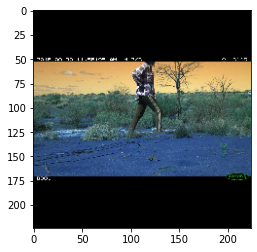

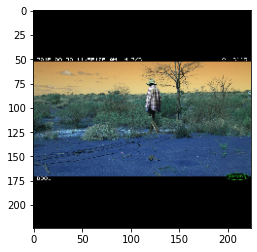

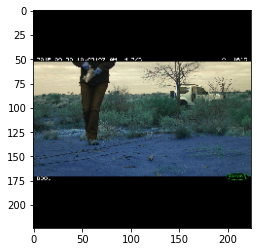

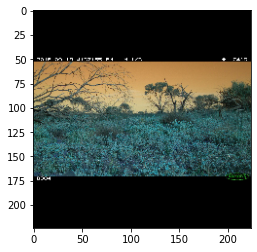

In [19]:
unlabelled_test_images = []
folders_dataset = next(os.walk('data/unlabelled_test_data/20160929_September'))[1]
folders_dataset = sorted(folders_dataset)
print('folders_dataset: {}'.format(folders_dataset))
for folder in folders_dataset:
    unlabelled_test_images = [*unlabelled_test_images, *readInImages('unlabelled_test_data/20160929_September', folder, False)]

displayImage(unlabelled_test_images[1])
displayImage(unlabelled_test_images[10])
displayImage(unlabelled_test_images[100])
displayImage(unlabelled_test_images[1000])

unlabelled_test_images = np.stack(unlabelled_test_images, axis = 0)

### Predict
* TODO: resolve encoded classes to their labels

In [20]:
y_pred = (model.predict(unlabelled_test_images) > 0.5).astype("int32")
y_classes = y_pred.argmax(axis=-1)
print('y_classes: {}'.format(y_classes))

102/102 [==============================] - 1s 14ms/step
y_classes: [6 6 6 ... 7 6 6]


## Save the model
* use the current date/time so we can keep incrementation progress of the model as we re-run it

In [21]:
now = datetime.now()
dt_string = now.strftime('%d-%m-%Y_%H:%M:%S')
print("saving model as: 'ZFNet-{}.h5'.'".format(dt_string))

model.save('saved_models/ZFNet-{}.h5'.format(dt_string))

saving model as: 'ZFNet-07-06-2022_11:02:26.h5'.'


## Free up the GPU's memory

In [22]:
cuda.select_device(0)
cuda.close()